In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model, Model, Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Input, SimpleRNN, LSTM, Dense,Dropout, Activation , Flatten, ConvLSTM2D, Conv2D, Reshape, TimeDistributed, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
import keras
import tensorflow as tf


In [2]:
#Ubicación de los archivos

Data = r"/Users/javier/Documents/Data/"   

Codigo = r'/Users/javier/Documents/Código/'

Cache = r'/Users/javier/Documents/Código/Cache/'

Imagenes = r'/Users/javier/Documents/Imagenes/'


#dswind= xr.open_dataset(path + 'download(2000-2009).nc') # set de presión

names = ['download(1979-1988).nc',
         'download(1989-1999).nc',
         'download(2000-2009).nc',
         ]

files = [Data + name for name in names]

dswind= xr.open_mfdataset(files)

df0 = pd.read_csv(Data + 'NCEP_Spectra2.csv',index_col='Unnamed: 0')  #Sólo los parámetros de oleaje, no es el espectro completo.

df02 = pd.read_csv(Data + 'NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912_paramsMIKE.csv',index_col='Unnamed: 0') 

Desde = '1979-01-01 03:00:00'

Hasta = '2009-12-30 21:00:00'

Fechas = df0[Desde: Hasta].index


In [3]:
'''
Hace un avarage pooling y luego un flatten si se le pide.

'''

def resize(Wind,i,j=1,padding='valid'):
    
    if len(X.shape) ==3:
    
        Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    Average_pool = AveragePooling2D(pool_size = i,strides = j ,padding=padding)#, strides= int(10*i)) #el poolsize y stride, están pensados para las futuras iteraciones

    model = Sequential([Average_pool]) 

    output = model.predict(Wind)    
    
    Wind = np.squeeze(output) 
    
    return Wind


def gradiente(X):
    
    grad = np.zeros(X.shape)
    
    for i in range(1,grad.shape[1]-1):
        
        for j in range(1,grad.shape[2]-1):
            
            grad[:,i,j] = np.sqrt((X[:,i-1,j]-X[:,i+1,j])**2 + (X[:,i,j-1]-X[:,i,j+1])**2) #magnitud de gradiente aunque le falta ser dividida por el diferencial de distancia entre puntos, pero al ser constante para todos los valores no debería afectar.
    
    return grad


def flatten(Var):
    
    return Var.reshape(Var.shape[0], Var.shape[1]*Var.shape[2])


def preparar_x(dswind, lotes = 20000, pooling = 1, flat = False):

    '''
    Función para poder crear un arreglo de datos que contenga todos los dato del dataserie,
    
    Es relevante, ya que se debe hacer por lotes para no exceder la capacidad de la RAM.
    
    lotes: int, corresponde al tamaño de cada lote a procesar mediante un avarage pooling
    
    pooling: int, densidad del avarage pooling.
    
    return, arreglo X correspondiente a la base de datos dswind completa con dimensión reducida

    '''


    Largototal = dswind.data.shape[0]

    j = lotes

    X = resize(np.array(dswind.isel(time = slice(0,j)).data), pooling)

    
    for i in range(lotes*2,Largototal,lotes):
        
        windpart = resize(np.array(dswind.isel(time = slice(j,i)).data), pooling)
        
        X = np.append(X,windpart, axis = 0)
        
        j = i
        
        print('Datos: ',i,'/',Largototal)
        
    windpart = resize(np.array(dswind.isel(time = slice(j,Largototal)).data), pooling)

    X = np.append(X,windpart, axis = 0)
    
    if flat:
        
        X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
    
    return X


def dividir(Var1, Var2, timestep, desfase):
    Var1_d = []

    for t in range(timestep+desfase, Var1.shape[0],timestep):
        
        Var1_d.append(Var1[t - timestep -desfase:t])
        
    Var1_d = np.array(Var1_d)

    Var2_d = []
    
    for t in range(timestep+desfase, Var2.shape[0],timestep):
            
        Var2_d.append(Var2[t - timestep:t])
        
    Var2_d = np.array(Var2_d)    
     
    return Var1_d, Var2_d


def normalize(X):
    
    return (X-X.min())/(X.max()-X.min())


def juntar(Var):
    
    return Var.reshape(Var.shape[0]*Var.shape[1],Var.shape[2])






def get_set(X, Y, timestep, traslape):
    
    scx2 = MinMaxScaler([0,1])
    
    X_div, Y_div =  dividir(normalize(X),scx2.fit_transform(Y), timestep, traslape)
   
    m = X_div.shape[0]

    x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

    y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]

    print('X_train shape: ', x_train.shape)
    print('Y_train shape: ', y_train.shape)

    return x_train, x_test, y_train, y_test, scx2

In [4]:
Hm0 = np.array(df0[Desde: Hasta]['Hm0']).reshape(-1,1)
Tp = np.array(df0[Desde: Hasta]['Tp']).reshape(-1,1)
MD = np.array(df0[Desde: Hasta]['Mean Dir']).reshape(-1,1)
DSD =  np.array(df0[Desde: Hasta]['DSD']).reshape(-1,1)
WP = np.array(df02[Desde: Hasta]['P1: Wave Period, T01']).reshape(-1,1)

In [5]:
'''Aquí se carga como X input, las características obtenidas de la red VGG16, en el código "obtención de características"'''

X = np.load(Cache + 'x_features_VGG(1979-2009).npy')

X =resize(X,3)

X = flatten(X)

In [89]:
"'Se carga X como los valores de presión, omitir si se quiere usar el X features del modelo pre-entrenado'"

X = np.load(Cache + 'Presión.npy')

X = resize(X,5,5,padding="same")

X = flatten(X)

X.shape

(90575, 560)

In [57]:
x_train, x_test, y_train, y_test, scy = get_set(X, Hm0, timestep= 100, traslape = 100)

X_train shape:  (723, 200, 1024)
Y_train shape:  (723, 100, 1)


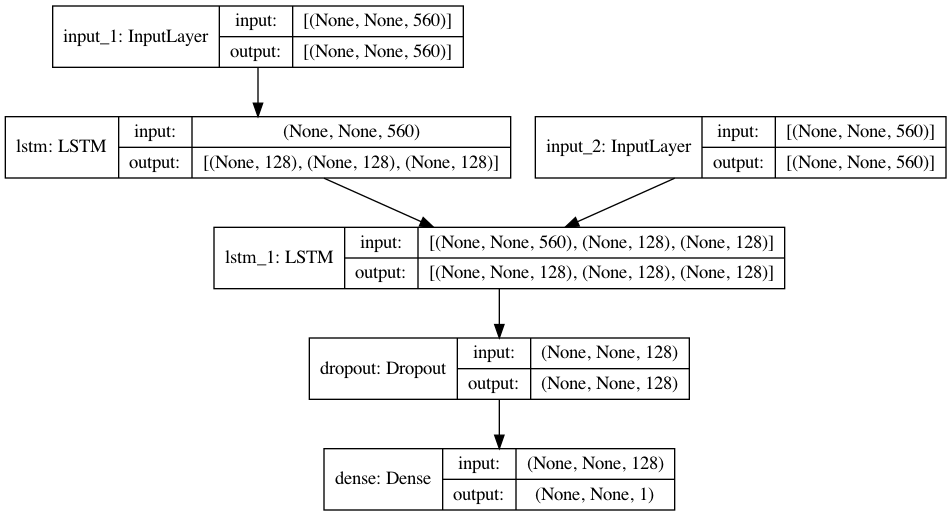

In [8]:


num_decoder_tokens = 1

hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, x_train.shape[2]))#,x_train.shape[3],x_train.shape[4]))

#encoder_outputs = TimeDistributed(MaxPooling2D(pool_size=3))(encoder_inputs)

#encoder_outputs = TimeDistributed(Flatten())(encoder_outputs)

#encoder_outputs = TimeDistributed(Dense(512))(encoder_outputs)

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.


decoder_inputs = Input(shape=(None, x_train.shape[2]))#,x_train.shape[3],x_train.shape[4]))

#decoder_outputs = TimeDistributed(MaxPooling2D(pool_size=3))(decoder_inputs)

#decoder_outputs = TimeDistributed(Flatten())(decoder_inputs)

#decoder_outputs = TimeDistributed(Dense(512))(decoder_outputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

#decoder_outputs = Dense(hidden_units)(decoder_outputs)

decoder_outputs = Dropout(0.5)(decoder_outputs)

decoder_outputs = Dense(num_decoder_tokens)(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file=Imagenes + 'model_parámetros.png', show_shapes=True)

In [9]:
x_train, x_test, y_train, y_test, scy = get_set(X, WP, timestep= 1, traslape = 60)
traslape = 60    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 20, batch_size=64 ,validation_split=0.1, shuffle = True)

X_train shape:  (72411, 61, 560)
Y_train shape:  (72411, 1, 1)
Epoch 1/20
1019/1019 [==============================] - 132s 126ms/step - loss: 0.1319 - val_loss: 0.0165
Epoch 2/20
1019/1019 [==============================] - 97s 95ms/step - loss: 0.0201 - val_loss: 0.0160
Epoch 3/20
1019/1019 [==============================] - 92s 91ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 4/20
1019/1019 [==============================] - 93s 91ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 5/20
1019/1019 [==============================] - 93s 91ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 6/20
1019/1019 [==============================] - 91s 89ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 7/20
1019/1019 [==============================] - 90s 89ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 8/20
1019/1019 [==============================] - 90s 88ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 9/20
1019/1019 [==============================] - 91s 89ms/step - loss: 0.0146 - val_loss: 0.0140

In [11]:
# Guardar el Modelo
model.save('/Users/javier/Documents/Código/Cache/Model_WP.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#model = keras.models.load_model(Cache + 'Model_WP.h5')

In [12]:
y_pred_train = juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]]))
y_pred_test = juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]]))
y_train = juntar(y_train)
y_test = juntar(y_test)

In [13]:
y_pred_test = scy.inverse_transform(y_pred_test)
y_test = scy.inverse_transform(y_test)

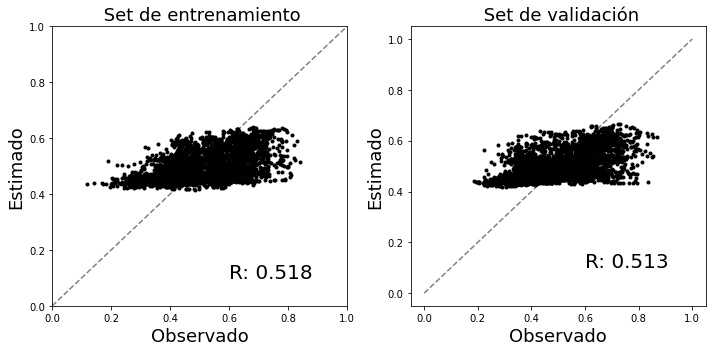

In [13]:



fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title(' Set de entrenamiento',fontsize=18)
axs[0].plot([0,1],[0,1],'--',0.5,color='grey')
axs[0].plot(y_train[:3000],y_pred_train[:3000],'.',color='Black')
axs[0].set_xlabel('Observado',size=18)
axs[0].set_ylabel('Estimado',size=18)
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[0].text(0.6,0.1,'R: '+str(np.round(np.corrcoef(y_train.T,(y_pred_train).T)[0,1],3)),size=20)


axs[1].set_title(' Set de validación',fontsize=18)
axs[1].plot([0,1],[0,1],'--',0.5,color='grey')
axs[1].plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs[1].set_xlabel('Observado',size=18)
axs[1].set_ylabel('Estimado',size=18)
#axs[1].set_ylim(0,1)
#axs[1].set_xlim(0,1)
axs[1].text(0.6,0.1,'R: '+str(np.round(np.corrcoef(y_test.T,y_pred_test.T)[0,1],3)),size=20)

fig.set_facecolor('w')
fig.tight_layout()
plt.show()

#fig.savefig("New_LSTM_Hm02",dpi=300)





Text(16, 6.2, 'R: 0.482')

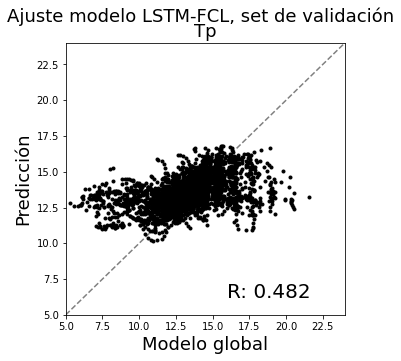

In [18]:



fig, axs = plt.subplots(1, 1, figsize=(5,5))

fig.suptitle('Ajuste modelo LSTM-FCL, set de validación',fontsize=18)


axs.set_title('Tp',fontsize=18)
axs.plot([5,24],[5,24],'--',0.5,color='grey')
axs.plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs.set_xlabel('Modelo global',size=18)
axs.set_ylabel('Predicción',size=18)
axs.set_ylim(5,24)
axs.set_xlim(5,24)
axs.text(16,6.2,'R: '+str(np.round(np.corrcoef(y_pred_test.T,(y_test).T)[0,1],3)),size=20)





## Se corre un modelo para cada varíable de oleaje y se guardan los ajustes del set de validación

In [49]:
x_train, x_test, y_train, y_test, scy = get_set(X, Hm0, timestep= 1, traslape = 60)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')
    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)


y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))


np.save(Cache + 'Hm0_test.npy', y_test)
np.save(Cache + 'Hm0_pred.npy', y_pred_test)

In [27]:
x_train, x_test, y_train, y_test, scy = get_set(X, Tp, timestep= 1, traslape = 60)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')
    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.save(Cache + 'Tp_test.npy', y_test)
np.save(Cache + 'Tp_pred.npy', y_pred_test)

In [ ]:
x_train, x_test, y_train, y_test, scy = get_set(X, MD, timestep= 1, traslape = 60)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')
    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)


y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))


np.save(Cache + 'MD_test.npy', y_test)

np.save(Cache + 'MD_pred.npy', y_pred_test)

print(np.round(np.corrcoef(y_pred_test.T,(y_test).T)[0,1],3))


X_train shape:  (72411, 61, 512)
Y_train shape:  (72411, 1, 1)
Epoch 1/30
1019/1019 [==============================] - 105s 100ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 2/30
1019/1019 [==============================] - 94s 93ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/30
1019/1019 [==============================] - 91s 89ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/30
1019/1019 [==============================] - 92s 90ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 5/30
1019/1019 [==============================] - 95s 93ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 6/30
1019/1019 [==============================] - 90s 89ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 7/30
1019/1019 [==============================] - 91s 89ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 8/30
1019/1019 [==============================] - 91s 89ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 9/30
1019/1019 [==============================] - 92s 91ms/step - loss: 0.0026 - val_loss: 0.0038

In [14]:
x_train, x_test, y_train, y_test, scy = get_set(X, DSD, timestep= 1, traslape = 60)

traslape =60

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.save(Cache + 'DSD_test.npy', y_test)
np.save(Cache + 'DSD_pred.npy', y_pred_test)

DSD_test = y_test
DSD_pred = y_pred_test

print(np.round(np.corrcoef(y_pred_test.T,(y_test).T)[0,1],3))

X_train shape:  (72411, 61, 512)
Y_train shape:  (72411, 1, 1)
Epoch 1/30
1019/1019 [==============================] - 125s 119ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 2/30
1019/1019 [==============================] - 105s 103ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 3/30
1019/1019 [==============================] - 111s 109ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 4/30
1019/1019 [==============================] - 115s 112ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 5/30
1019/1019 [==============================] - 109s 107ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 6/30
1019/1019 [==============================] - 110s 108ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 7/30
1019/1019 [==============================] - 110s 108ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 8/30
1019/1019 [==============================] - 110s 108ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 9/30
1019/1019 [==============================] - 111s 109ms/step - loss: 0.0069 - 

In [159]:
x_train, x_test, y_train, y_test, scy = get_set(X, WP, timestep= 1, traslape = 60)

traslape =60

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.save(Cache + 'WP_test.npy', y_test)
np.save(Cache + 'WP_pred.npy', y_pred_test)

print(np.round(np.corrcoef(y_pred_test.T,(y_test).T)[0,1],3))

X_train shape:  (72411, 61, 512)
Y_train shape:  (72411, 1, 1)
Epoch 1/30
1019/1019 [==============================] - 112s 106ms/step - loss: 0.0264 - val_loss: 0.0165
Epoch 2/30
1019/1019 [==============================] - 92s 90ms/step - loss: 0.0182 - val_loss: 0.0156
Epoch 3/30
1019/1019 [==============================] - 89s 88ms/step - loss: 0.0163 - val_loss: 0.0140
Epoch 4/30
1019/1019 [==============================] - 92s 91ms/step - loss: 0.0143 - val_loss: 0.0128
Epoch 5/30
1019/1019 [==============================] - 87s 86ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 6/30
1019/1019 [==============================] - 86s 84ms/step - loss: 0.0129 - val_loss: 0.0150
Epoch 7/30
1019/1019 [==============================] - 92s 90ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 8/30
1019/1019 [==============================] - 92s 91ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 9/30
1019/1019 [==============================] - 89s 88ms/step - loss: 0.0121 - val_loss: 0.0124

In [160]:
Hm0_test = np.load(Cache + 'Hm0_test.npy')
Hm0_pred = np.load(Cache + 'Hm0_pred.npy')

Tp_test = np.load(Cache + 'WP_test.npy')
Tp_pred = np.load(Cache + 'WP_pred.npy')               

MD_test = np.load(Cache + 'MD_test.npy')
MD_pred = np.load(Cache + 'MD_pred.npy')

DSD_test = np.load(Cache + 'DSD_test.npy')
DSD_pred = np.load(Cache + 'DSD_pred.npy')

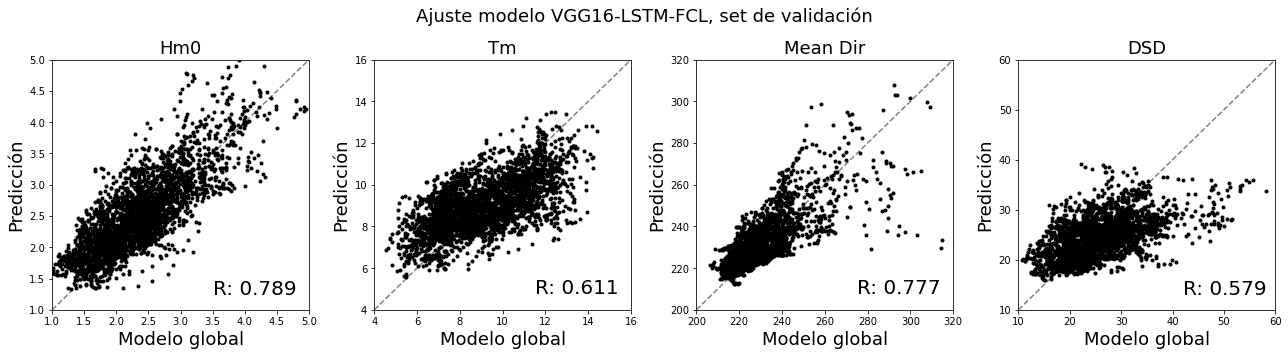

In [167]:
#y_pred = (juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

#y_test = (juntar(y_test))


fig, axs = plt.subplots(1, 4, figsize=(18,5))

fig.suptitle('Ajuste modelo VGG16-LSTM-FCL, set de validación',fontsize=18)

axs[0].set_title('Hm0',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(Hm0_test[:3000,0],Hm0_pred[:3000,0],'.',color='Black')
axs[0].set_xlabel('Modelo global',size=18)
axs[0].set_ylabel('Predicción',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(Hm0_test.T,(Hm0_pred).T)[0,1],3)),size=20)

axs[1].set_title('Tm',fontsize=18)
axs[1].plot([4,16],[4,16],'--',0.5,color='grey')
axs[1].plot(Tp_test[:3000],Tp_pred[:3000],'.',color='Black')
axs[1].set_xlabel('Modelo global',size=18)
axs[1].set_ylabel('Predicción',size=18)
axs[1].set_ylim(4,16)
axs[1].set_xlim(4,16)
axs[1].text(11.5,4.8,'R: '+str(np.round(np.corrcoef(Tp_test.T,(Tp_pred).T)[0,1],3)),size=20)

axs[2].set_title('Mean Dir',fontsize=18)
axs[2].plot([200,320],[200,320],'--',0.5,color='grey')
axs[2].plot(MD_test[:3000],MD_pred[:3000],'.',color='Black')
axs[2].set_xlabel('Modelo global',size=18)
axs[2].set_ylabel('Predicción',size=18)
axs[2].set_ylim(200,320)
axs[2].set_xlim(200,320)
axs[2].text(275,208,'R: '+str(np.round(np.corrcoef(MD_test.T,(MD_pred).T)[0,1],3)),size=20)

axs[3].set_title('DSD',fontsize=18)
axs[3].plot([10,60],[10,60],'--',0.5,color='grey')
axs[3].plot(DSD_test[:3000],DSD_pred[:3000],'.',color='Black')
axs[3].set_xlabel('Modelo global',size=18)
axs[3].set_ylabel('Predicción',size=18)
axs[3].set_ylim(10,60)
axs[3].set_xlim(10,60)
axs[3].text(42,13,'R: '+str(np.round(np.corrcoef(DSD_test.T,(DSD_pred).T)[0,1],3)),size=20)

fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig(Imagenes + "Variables_VGG16_LSTM_2",dpi=300)

## Espectro de oleaje completo

In [34]:
import funciones as fn
import params_from_spectra as spectra


def plot_espectro(data,i,j,time,ax,levels,cbar=False):

    deltaf= i[1]-i[0]
    f=[]
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = pd.DataFrame(columns = j, index = [1/freq for freq in f], 
                        data = data[time,:,:])

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (4,4), cmap = 'viridis', cbar = cbar, cbar_label = None, 
                 levels = levels, ax = ax, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)


def obtener_hm0_tp(data, i,j):
    
    deltaf= i[1]-i[0]
    f=[]
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = []        
    for t in range(data.shape[0]):
        
        df.append(pd.DataFrame(columns = f, index = j, 
            data = data[t,:,:].T))
    units = 'rad'
 
    return spectra.params_from_spectra(df, item = None, units = units)


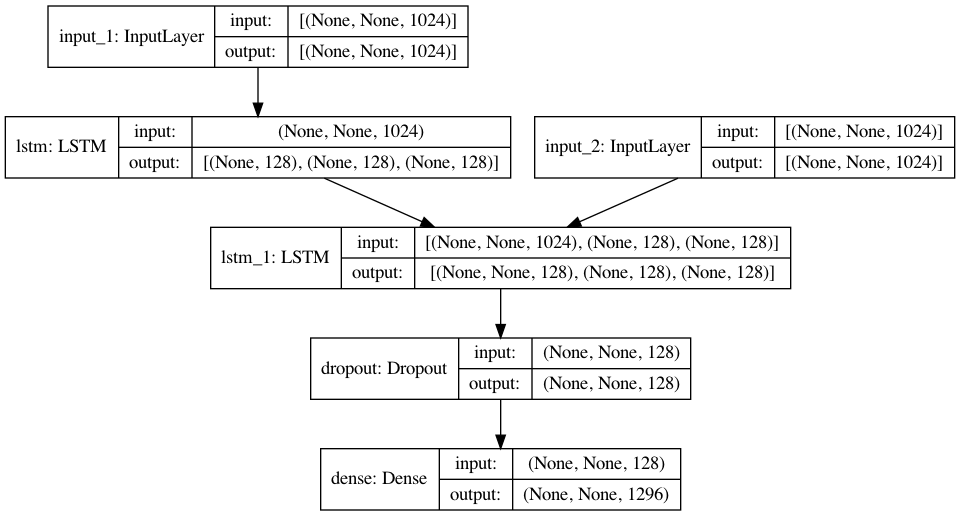

In [48]:
num_encoder_tokens = x_train.shape[2]
num_decoder_tokens = int(36*36)
hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, num_encoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_outputs = Dropout(0.5)(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens)

decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file=Imagenes + 'model_espectro.png', show_shapes=True)

In [60]:
Espectro = xr.open_dataset(Data + 'NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.nc')

In [61]:
i = Espectro.i.data

j = Espectro.j.data

time = Espectro.Timestep.sel(Timestep = slice(Desde,Hasta)).data

Y = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

Y = Y.reshape(Y.shape[0],Y.shape[1]*Y.shape[2])

In [90]:
traslape = 60

x_train, x_test, y_train, y_test, scy = get_set(X, Y, timestep= 1, traslape = traslape)



X_train shape:  (72411, 61, 560)
Y_train shape:  (72411, 1, 1296)


In [ ]:
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 2,batch_size=64 ,validation_split=0.1, shuffle = True)

In [74]:
y_train = juntar(y_train)
y_test = juntar(y_test)

In [75]:
m=y_train.shape[0]

In [76]:
y_test = scy.inverse_transform(y_test.reshape(y_test.shape[0],1296)).reshape(y_test.shape[0],36,36)
y_train = scy.inverse_transform(y_train.reshape(y_train.shape[0],1296)).reshape(y_train.shape[0],36,36)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))
y_pred_test = y_pred_test.reshape(y_pred_test.shape[0],36,36)

y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]])))
y_pred_train = y_pred_train.reshape(y_pred_train.shape[0],36,36)

/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:333: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under('whitesmoke')
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:338: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if levels == 'auto':
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{}s'.format(x) for x in ax.get_yticks()])


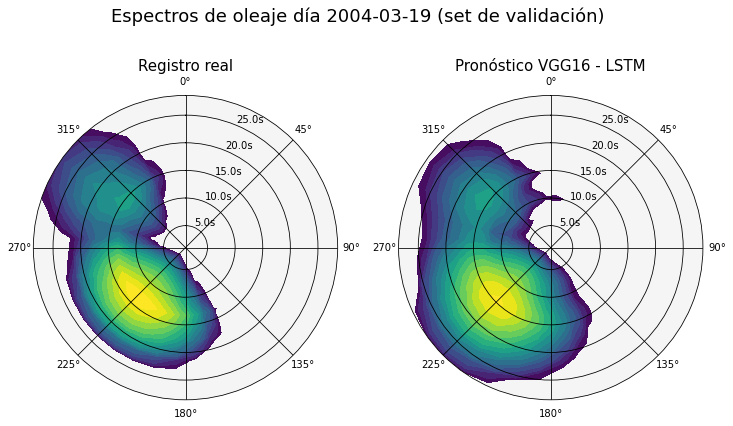

In [77]:
indice = 1200

levels = np.geomspace(0.01, 15, 16)


fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(time[int(m+traslape +indice)])[:10] + ' (set de validación)',fontsize=18)

plot_espectro(y_test,i,j,indice,axs[0],levels)

axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred_test,3),i,j,indice,axs[1],levels)

axs[1].set_title('Pronóstico VGG16 - LSTM',fontsize=15)

#plot_espectro(np.round(y_pred_train,3),i,j,indice,axs[2],levels)
#axs[2].set_title('Pronóstico LSTM-FCL',fontsize=15)

fig.set_facecolor('w')

fig.savefig(Imagenes + "Espectro_trainset_LSTM_4",dpi=300)

In [81]:
Hm0_spectra_obs,Tp_spectra_obs = obtener_hm0_tp(y_test,i,j)

<class 'list'>


In [80]:
Hm0_spectra_pred,Tp_spectra_pred = obtener_hm0_tp(y_pred_test,i,j)

<class 'list'>


In [86]:
# Guardar el Modelo
#model.save(Cache + 'Model_VGG16-LSTM.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model(Cache + 'Model_espectro_LSTM.h5')

In [83]:
np.corrcoef(Hm0_spectra_pred,Hm0_spectra_obs)

array([[1.        , 0.79586693],
       [0.79586693, 1.        ]])

In [84]:
np.corrcoef(Tp_spectra_pred,Tp_spectra_obs)

array([[1.        , 0.24715289],
       [0.24715289, 1.        ]])

## Ridge regresor

In [1]:
traslape = 60

x, y = dividir(X,Y, 1,traslape)

m = y.shape[0]

x = x.reshape(m,int((traslape+1)*x.shape[2]))

y = y.reshape(m,1*1296)

x_train, x_test, y_train, y_test = x[:int(m*0.8)], x[int(m*0.8):], y[:int(m*0.8)], y[int(m*0.8):]

NameError: name 'dividir' is not defined

In [87]:
from sklearn import linear_model

regresor = linear_model.Ridge(alpha=.5,normalize=True)

regresor.fit(x_train,y_train) 

Ridge(alpha=0.5, normalize=True)

In [127]:
y_pred = regresor.predict(x_test)

In [128]:
y_test = y_test.reshape(y_test.shape[0],36,36)
y_pred = y_pred.reshape(y_pred.shape[0],36,36)

NameError: name 'y_pred' is not defined

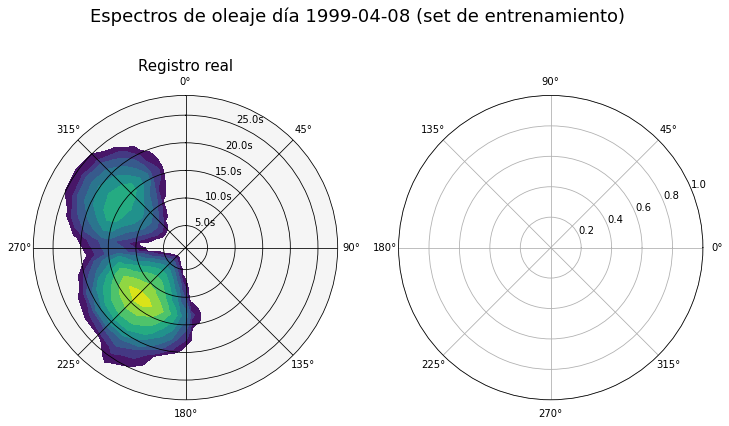

In [69]:
indice = 1230

levels = np.geomspace(0.01, 15, 10)

fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(time[int(m*0.8+1+traslape +indice)])[:10] + ' (set de entrenamiento)',fontsize=18)

plot_espectro(y_test,i,j,indice,axs[0],levels)

axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred,3),i,j,indice,axs[1],levels)

axs[1].set_title('Pronóstico Ridge',fontsize=15)

fig.set_facecolor('w')

fig.savefig("Espectro_trainset_ridge_4",dpi=300)

In [134]:
Hm0[int(traslape + 1 + m*0.8 + indice)]

array([3.02999997])

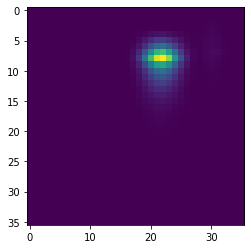

In [138]:
plt.imshow(y_test[indice,:,:])

In [141]:
y_test[indice,:,:].max()

22.109092712402344

In [120]:
m+traslape

90574

In [113]:
Y.shape

(90575, 1296)

In [64]:
from sklearn.metrics import mean_squared_error

MSE = []

for q in range(y_train.shape[0]):
    
    MSE.append(mean_squared_error(y_train[q], y_pred_train[q]))
    
MSE = np.array(MSE)



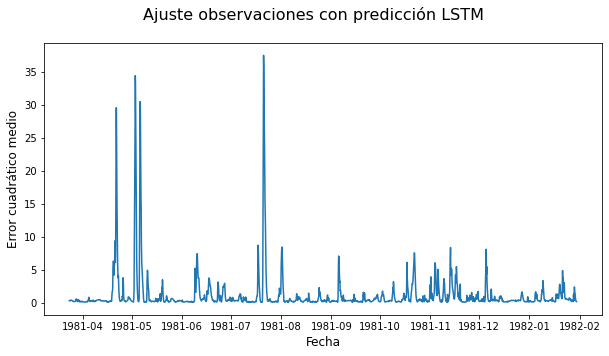

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(train_time[6500:9000],MSE[6500:9000])
fig.suptitle('Ajuste observaciones con predicción LSTM',fontsize=16)
ax.set_ylabel('Error cuadrático medio',fontsize=12)
ax.set_xlabel('Fecha',fontsize=12)
fig.set_facecolor('w')
fig.savefig('MSE_lstm', dpi=300)


In [86]:
train_time = train_time.reshape(-1,1)

tt = dividir(train_time[traslape:],1000)

tt = juntar(tt[int(0.8*tt.shape[0]):])


test_Hm0 = dividir(Hm0[traslape:],1000)

test_Hm0 = juntar(test_Hm0[int(0.8*test_Hm0.shape[0]):])

train_Hm0 = dividir(Hm0[traslape:],1000)

train_Hm0 = juntar(train_Hm0[:int(0.8*train_Hm0.shape[0])])

In [84]:
test_Hm0[1000]

I=i
J=j

In [81]:
dj = (J[2]-J[1])*2*np.pi/360   # delta j en rad
di = np.round((I[2]-I[1]),3)

In [96]:
y_train1 =y_train.reshape(-1,36*36)
y_test1 =y_test.reshape(-1,36*36)

In [95]:
from sklearn import linear_model

regresor = linear_model.Ridge(alpha=.5,normalize=True)
regresor = regresor.fit(y_train1,train_Hm0) 

In [83]:
u = np.round(y_test[1000],3)

In [97]:
pred_Hm0 = regresor.predict(y_test1)

In [99]:
pred_Hm0.shape

(18000, 1)

In [100]:
np.corrcoef(test_Hm0.T,pred_Hm0.T)

array([[1.       , 0.8587835],
       [0.8587835, 1.       ]])